In [1]:
import os
import shutil

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import thejoker as tj
import tables as tb
from schwimmbad import MultiPool

from hq.config import Config
from hq.data import get_rvdata

from scipy.stats import truncnorm as _truncnorm
def truncnorm(mu, sigma, clip_a, clip_b):
    a, b = (clip_a-mu)/sigma, (clip_b-mu)/sigma
    return _truncnorm(loc=mu, scale=sigma, a=a, b=b)

In [ ]:
with MultiPool() as pool:
    pool_size = pool.size

In [2]:
def fast_m2_min(m1, mf):
    return (2*mf + np.power(2,0.6666666666666666)*
      np.power(mf*(27*pow(m1,2) + 18*m1*mf + 2*np.power(mf,2) + 
          3*np.sqrt(3)*np.sqrt(np.power(m1,3)*(27*m1 + 4*mf))),0.3333333333333333) + 
     (2*mf*(6*m1 + mf))/
      np.power((27*np.power(m1,2)*mf)/2. + 9*m1*np.power(mf,2) + np.power(mf,3) + 
        (3*np.sqrt(3)*mf*np.sqrt(np.power(m1,3)*(27*m1 + 4*mf)))/2.,0.3333333333333333))/6.

In [3]:
c = Config.from_run_name('dr16')

In [4]:
allstar, allvisit = c.load_alldata()

---

In [5]:
metadata = at.QTable.read(c.metadata_path)
master = at.join(metadata, allstar, keys='APOGEE_ID')

APW cross-match to Gaia from 2MASS ID:

In [11]:
gaia = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR16/allStar-r12-gaiadr2.fits')
_, idx = np.unique(gaia['apogee_id'], return_index=True)
gaia = gaia[idx]
gaia.rename_column('apogee_id', 'APOGEE_ID')

for col in gaia.colnames:
    gaia[col].unit = None

master = at.join(master, gaia, keys='APOGEE_ID')

Stellar masses from StarHorse2019: https://data.aip.de/projects/starhorse2019.html

In [12]:
tbl = at.Table()
tbl['source_id'] = np.load('/mnt/home/apricewhelan/data/starhorse/all-source_id.npz')['arr_0']
tbl['mass'] = np.load('/mnt/home/apricewhelan/data/starhorse/all-mass50.npz')['arr_0']

err1 = tbl['mass'] - np.load('/mnt/home/apricewhelan/data/starhorse/all-mass16.npz')['arr_0']
err2 = np.load('/mnt/home/apricewhelan/data/starhorse/all-mass84.npz')['arr_0'] - tbl['mass']
tbl['mass_err'] = np.max([err1, err2], axis=0)

In [7]:
pre_idx = np.isin(tbl['source_id'], master['source_id'])

In [13]:
print(len(master))
master = at.join(master, tbl[pre_idx], keys='source_id', join_type='left')
master['mass'] = master['mass'].filled(np.nan)
print(len(master))

231253
231253


In [53]:
master.write('../catalogs/dr16_gaia_starhorse_metadata.fits', overwrite=True)

In [6]:
master = at.QTable.read('../catalogs/dr16_gaia_starhorse_metadata.fits')

In [7]:
len(master)

231253

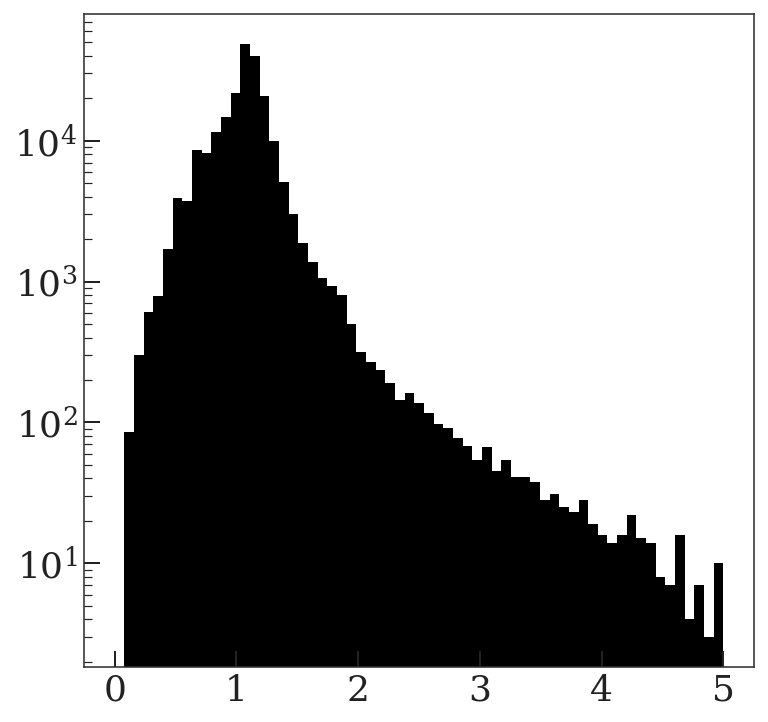

In [8]:
plt.hist(master['mass'], bins=np.linspace(0, 5, 64));
plt.yscale('log')

### Now load stars that pass the evidence ratio cut:

In [9]:
all_samples = at.Table.read('../catalogs/evidence_ratio_samples.hdf5')
all_samples['APOGEE_ID'] = all_samples['APOGEE_ID'].astype(str)
len(all_samples)

10868064

In [10]:
master_cut = master[np.isin(master['APOGEE_ID'], all_samples['APOGEE_ID'])
                    & np.isfinite(master['mass'])]
len(master_cut)

20677

In [18]:
from thejoker.multiproc_helpers import batch_tasks
tasks = batch_tasks(len(master_cut), pool_size, arr=master_cut)

In [19]:
percentiles = [5, 50, 95]

def worker(task):
    rows, id_ = task
    
    print(f"worker {id_} has {len(rows)} tasks")
    
    tmp = []
    for row in rows:
        samples = all_samples[all_samples['APOGEE_ID'] == row['APOGEE_ID']]

        if len(samples) < 10:
            n_m1 = 128
        else:
            n_m1 = 4

        m1_samples = truncnorm(row['mass'], row['mass_err'], 0, 1e3).rvs(size=(len(samples), n_m1)).ravel() * u.Msun
        mf = np.repeat(samples['m_f'][:, None], n_m1, axis=1).ravel() * u.Msun
        # m2_min = get_m2_min(m1_samples, mf)
        m2_min = fast_m2_min(m1_samples.value, mf.value)
        tmp.append(np.nanpercentile(m2_min, percentiles))
        
    return tmp

m2_min_percentiles = []
with MultiPool() as pool:
    for res in pool.map(worker, tasks):
        m2_min_percentiles.append(res)
        
m2_min_percentiles = np.array([l for x in m2_min_percentiles for l in x ])

worker 0 has 739 tasks
worker 739 has 739 tasks
worker 2217 has 739 tasks
worker 1478 has 739 tasks
worker 2956 has 739 tasks
worker 3695 has 739 tasks
worker 4434 has 739 tasks
worker 5173 has 739 tasks
worker 5912 has 739 tasks
worker 6651 has 739 tasks
worker 7390 has 739 tasks
worker 9607 has 738 tasks
worker 8868 has 739 tasks
worker 8129 has 739 tasks
worker 10345 has 738 tasks
worker 11083 has 738 tasks
worker 11821 has 738 tasks
worker 12559 has 738 tasks
worker 13297 has 738 tasks
worker 14035 has 738 tasks
worker 14773 has 738 tasks
worker 15511 has 738 tasks
worker 16249 has 738 tasks
worker 16987 has 738 tasks
worker 17725 has 738 tasks
worker 18463 has 738 tasks
worker 19201 has 738 tasks
worker 19939 has 738 tasks


/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encou

In [30]:
for i, val in enumerate(percentiles):
    master_cut[f'm2_min_{val}'] = m2_min_percentiles[:, i] * u.Msun

In [36]:
master_cut.write('../catalogs/evidence_ratio_metadata_gaia_starhorse.fits')

In [40]:
((master_cut['m2_min_95'] < 0.1*u.Msun) & (master_cut['n_visits'] >= 5)).sum()

1591

In [32]:
(master_cut['m2_min_5'] > 1.5*u.Msun).sum()

64

In [35]:
((master_cut['m2_min_5'] > 1.5*u.Msun) & (master_cut['m2_min_5'] > master_cut['mass']*u.Msun)).sum()

50